In [1]:
import gym
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

In [2]:
######################################################################
# CartPole ( https://www.gymlibrary.dev/environments/classic_control/cart_pole/ )
#=====================================================================
env = gym.make("CartPole-v1", render_mode="rgb_array")
env.reset()
env

<TimeLimit<OrderEnforcing<PassiveEnvChecker<CartPoleEnv<CartPole-v1>>>>>

In [3]:
# minimum and maximum of [cart_position, cart_velocity, pole_angle, pole_angular_velocity]
env.observation_space 

Box([-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38], (4,), float32)

In [4]:
env.action_space # 0 or 1

Discrete(2)

In [5]:
env.action_space.sample() # random action

1

In [6]:
# take a random action
observation, reward, terminated, truncated, info = env.step(env.action_space.sample())
observation, reward, terminated, truncated, info

(array([-0.03758457,  0.20546399, -0.01359382, -0.26831868], dtype=float32),
 1.0,
 False,
 False,
 {})

In [7]:
env_screen = env.render() # numpy.ndarray
env_screen.shape

(400, 600, 3)

In [8]:
env_screen

array([[[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       ...,

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]]

In [9]:
import gym
import numpy as np

# iteration
env = gym.make("CartPole-v1", render_mode="rgb_array")
env.reset()

total_reward = 0.0
terminated = False
env_screens = []
while not terminated:
    observation, reward, terminated, truncated, info = env.step(env.action_space.sample())
    env_screen = env.render() # numpy.ndarray
    env_screens.append(env_screen)
    total_reward += reward

env.close()
total_reward

23.0

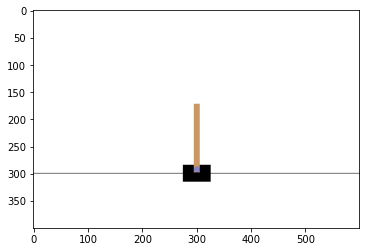

In [10]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

####################################################
# create an animation
#===================================================

fig, ax = plt.subplots()
im = ax.imshow(env_screens[0])

def update(i):
    im.set_data(env_screens[i])
    return (im)

animation = FuncAnimation(fig=fig, func=update, frames=len(env_screens), interval=100)
#plt.show()

# display the animation in the notebook
HTML(animation.to_jshtml())

In [11]:
#################################################################
# compute the expected reward if we always take random actions
#################################################################

import gym
import numpy as np

env = gym.make("CartPole-v1", render_mode="rgb_array")
NUM_EPISODES = 1000
rewards = np.zeros(NUM_EPISODES)

for episode in range(NUM_EPISODES):
    env.reset()
    observation, reward, terminated, truncated, info = env.step(env.action_space.sample())
    total_reward = reward
    while not terminated:
        # take a random action
        action = env.action_space.sample()
        next_observation, reward, terminated, truncated, info = env.step(action)
        total_reward += reward
    rewards[episode] = total_reward
env.close()

rewards.mean() # expected reward is about 22

22.215

In [12]:
# observation
env.reset()
observation, reward, terminated, truncated, info = env.step(env.action_space.sample())
cart_position, cart_velocity, pole_angle, pole_angular_velocity = observation

# 4 values of a state
print(cart_position, cart_velocity, pole_angle, pole_angular_velocity)

int_arr = (observation > 0).astype('int')
int_arr

-0.008612889 0.19729768 0.040150084 -0.24922904


array([0, 1, 1, 0])

In [13]:
###########################################################
# q learning  
###########################################################

# this script is not powerful but above average. 
# if you are lucky, you get more than 100 reward.
# the performance highly depends on parameters.

import gym
import numpy as np

def run_epoch(q_table=None, training=True):
    # parameters 
    ALPHA = 0.1 # learning rate
    GAMMA = 0.99 # discount factor
    eps = 1 if training == True else 0.1
    epsilon_decay = 0.99
    
    # there are only 2*2*2*2 states, because we only consider whether values of a state are positive or not
    if q_table is None:
        q_table = np.random.random((2, 2, 2, 2, 2))
        
    NUM_EPISODES = 200
    rewards = np.zeros(NUM_EPISODES)
    env = gym.make("CartPole-v1", render_mode="rgb_array")

    for episode in range(NUM_EPISODES):
        observation, info = env.reset() # initialize
        episode_reward = 0.0
        terminated = False
        while not terminated:
            state = (observation > 0).astype('int') # 1D array of integers

            # choose an action by epsilon greedy method
            if np.random.random() <= eps:
                action = env.action_space.sample()
            else:
                action = np.argmax(q_table[tuple(state)])
            
            # q_table index
            q_index = (*tuple(state), action) # tuple of integers

            # take an action
            next_observation, reward, terminated, truncated, info = env.step(action)

            # q table update
            if training:
                next_state = (next_observation > 0).astype('int')
                max_q = q_table[tuple(next_state)].max()
                current_q = q_table[q_index] 
                q_table[q_index] += ALPHA * (reward + GAMMA * max_q - current_q)

            # prepare next iteration
            observation = next_observation
            episode_reward += reward
            eps *= epsilon_decay

        # record the result
        rewards[episode] = episode_reward

    env.close()
    return rewards.mean(), q_table


####################################################
# run epochs
#===================================================

best_avg_reward = 0
best_q_table = None
for _ in range(100):
    epi_avg, q_table = run_epoch()
    # record the best reward and q_table
    if epi_avg > best_avg_reward:
        best_avg_reward = epi_avg
        best_q_table = q_table
        print(f"new record: episode reward avearage {best_avg_reward}")
print("Done.")

best_avg_reward, best_q_table

new record: episode reward avearage 115.415
new record: episode reward avearage 127.63
new record: episode reward avearage 148.26
new record: episode reward avearage 161.86
Done.


(161.86,
 array([[[[[97.15365374,  2.16495431],
           [ 1.47885627, 97.14907253]],
 
          [[ 0.44878413, 88.01168059],
           [ 1.40258502, 62.44373812]]],
 
 
         [[[96.72115968,  0.97994409],
           [ 0.35990912, 84.22374997]],
 
          [[ 0.6903238 , 93.03625292],
           [ 0.36077493, 49.10313116]]]],
 
 
 
        [[[[91.78432801,  1.10712705],
           [ 0.66908302, 92.3365924 ]],
 
          [[ 0.34401712, 62.28208081],
           [13.59917839,  0.18875213]]],
 
 
         [[[91.27872717,  2.24574549],
           [79.68497241,  0.80003892]],
 
          [[ 0.91320213, 88.51411084],
           [ 0.37257885, 39.1341404 ]]]]]))

In [14]:
epi_avg, q_table = run_epoch(best_q_table, training=False)
epi_avg, q_table

(162.52,
 array([[[[[97.15365374,  2.16495431],
           [ 1.47885627, 97.14907253]],
 
          [[ 0.44878413, 88.01168059],
           [ 1.40258502, 62.44373812]]],
 
 
         [[[96.72115968,  0.97994409],
           [ 0.35990912, 84.22374997]],
 
          [[ 0.6903238 , 93.03625292],
           [ 0.36077493, 49.10313116]]]],
 
 
 
        [[[[91.78432801,  1.10712705],
           [ 0.66908302, 92.3365924 ]],
 
          [[ 0.34401712, 62.28208081],
           [13.59917839,  0.18875213]]],
 
 
         [[[91.27872717,  2.24574549],
           [79.68497241,  0.80003892]],
 
          [[ 0.91320213, 88.51411084],
           [ 0.37257885, 39.1341404 ]]]]]))